In [104]:
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from src.models.BaseRegressor import BaseRegressor
from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
gpus = tf.config.list_physical_devices()
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [106]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .drop_features(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
                      .split_data(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)
processor_pipe.processed_data

,mouse_id,sensor,sex,day,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,ratio_avoid
0,0,D1,F,1,3.127942,-1.445911,183.380890,307.363281,-123.982407,0.178571
1,0,DA,F,1,2.314936,-3.262590,-107.717682,132.883179,-240.600861,0.178571
2,0,D1,F,1,2.974904,-1.432352,399.498169,459.798584,-60.300407,0.178571
3,0,D1,F,1,0.731579,-2.503899,-358.554230,24.004738,-382.558990,0.178571
4,0,D1,F,1,1.076792,-2.716747,-424.765411,24.113791,-448.879211,0.178571
...,...,...,...,...,...,...,...,...,...,...
12416,13,DA,M,7,2.598939,-2.246814,49.042274,189.407471,-140.365204,1.000000
12417,13,D2,M,7,3.042648,-1.698893,159.018143,244.892090,-85.873940,1.000000
12418,13,DA,M,7,3.537512,-2.393753,-82.977081,174.050079,-257.027161,1.000000
12419,13,D2,M,7,3.150901,-1.644451,145.029205,236.765778,-91.736565,1.000000


In [111]:
# {'batch size': 64,
#  'dropout rate': 0.2,
#  'epochs': 200,
#  'learning rate': 1e-05,
#  'number of layers': 3,
#  'number of units': 20,
#  'optimizers': 'adam'}

model = BaseRegressor(
    num_features=processor_pipe.X_train.shape[1],
    number_of_layers=3,
    number_of_units=5,
    dropout_rate=0.2)
metrics = [tf.keras.metrics.MeanSquaredError(name='mse'),
           tf.keras.metrics.MeanAbsoluteError(name='mae')]
  
model.compile(optimizer='adam',loss='mean_squared_error', metrics=metrics)


In [112]:
model.fit(processor_pipe.X_train, 
          processor_pipe.y_train, 
          epochs=200,
          batch_size=32)

Epoch 1/200


2023-11-08 16:33:19.574527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 2s 6ms/step - loss: 2.7868 - mse: 2.7868 - mae: 1.2532
Epoch 2/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1701
Epoch 3/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1504
Epoch 4/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1451
Epoch 5/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0306 - mae: 0.1443
Epoch 6/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0338 - mae: 0.1497
Epoch 7/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1672
Epoch 8/200
248/248 [==============================] - 1s 5ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2136
Epoch 9/200
248/248 [==============================] - 1s 5ms/step - loss: 0.1849 - mse: 0.1849 - mae: 0.2878
Epoch 10/200
248/248 [

KeyboardInterrupt: 

In [102]:
model.evaluate(processor_pipe.X_dev, processor_pipe.y_dev)

41/59 [===================>..........] - ETA: 0s - loss: 0.8007 - mse: 0.8007 - mae: 0.8540

2023-11-08 16:31:08.904925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 0s 4ms/step - loss: 0.7618 - mse: 0.7618 - mae: 0.8420


[0.7618160247802734, 0.7618160247802734, 0.8420343399047852]

In [91]:
predictions = model.predict(processor_pipe.X_test)

82/82 [==============================] - 0s 2ms/step


2023-11-08 16:26:20.122312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [92]:
print(predictions.shape)
processor_pipe.X_test[:,1].shape

(2613, 1)


(2613,)

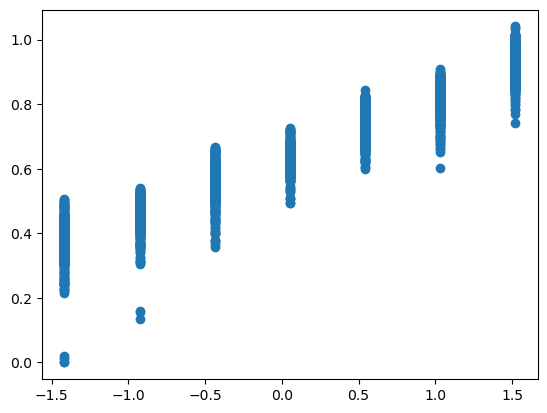

In [93]:
plt.scatter(processor_pipe.X_test[:,1], predictions)